# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [400]:
import pandas as pd
import numpy as np 
import pylab 
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/human_body_temperature.csv')

# Print the data frame information
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB
None


## Data Insight: EDA
Based on the info, there data frame has three columns and 130 rows.
None of the columns has missing values. 
For most the following code, temperature columns will be the main focus.
The column value is extracted as 1D array.
Then a box plot of temperature data is created using seaborn's boxplot.

In [366]:
# Extract the pandas series values in an array
temp = df.temperature.values

AttributeError: 'int' object has no attribute 'temperature'

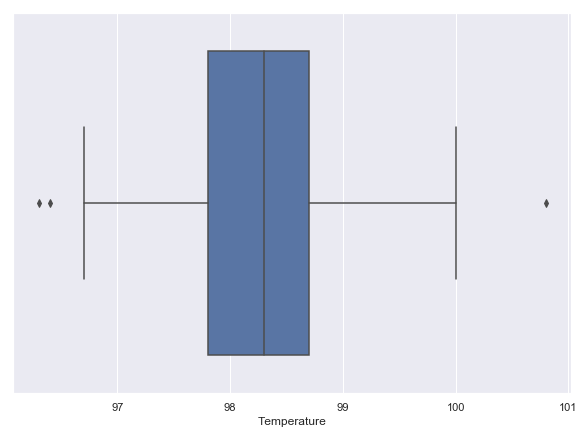

In [367]:
# Box Plot
plt.figure(figsize=(10, 7))
_ = sns.boxplot(temp)
_ = plt.xlabel('Temperature')

The box plot suggests that there are few outliers in the data. Since some of the statistics computed below
are sensitive to the outliers (especailly t-statistic), a cleaned temp data set without outliers has been created.
This is done just to ensure that the outliers do not have a significant impact on the normality of sample distribution.

In [368]:
# Compute the first and third quantile.
Q1, Q3  = np.percentile(temp, [25,75])
IQR = Q3 - Q1
# left (lower) whisker
low = Q1 - 1.5 * IQR
# right (upper) whisker
high = Q3 + 1.5 * IQR
print("No of outliers on left: ", np.sum(temp < low))
print("No of outliers on right: ", np.sum(temp > high))
# remove the three outliers from the data and store in a new clean array
temp_clean = temp[np.logical_and(temp >= low,temp <= high)]


No of outliers on left:  2
No of outliers on right:  1


# Normality Tests - Graphical and Numerical

Text(0.5,1,'Distribution Plot - Cleaned Data')

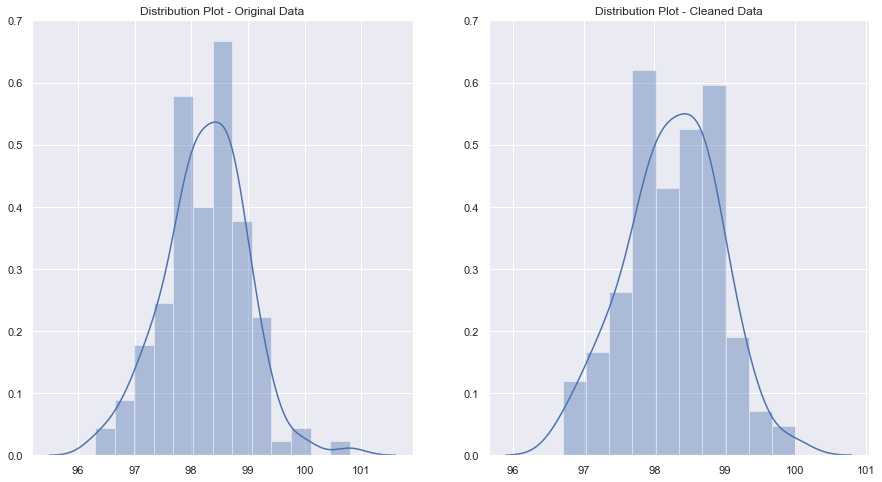

In [369]:
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(121)
ax1.set_ylim([0,0.7])
ax1.set_title('Distribution Plot - Original Data')
_ = sns.distplot(temp)
ax2 = plt.subplot(122)
_ = sns.distplot(temp_clean)
ax2.set_ylim([0,0.7])
ax2.set_title('Distribution Plot - Cleaned Data')

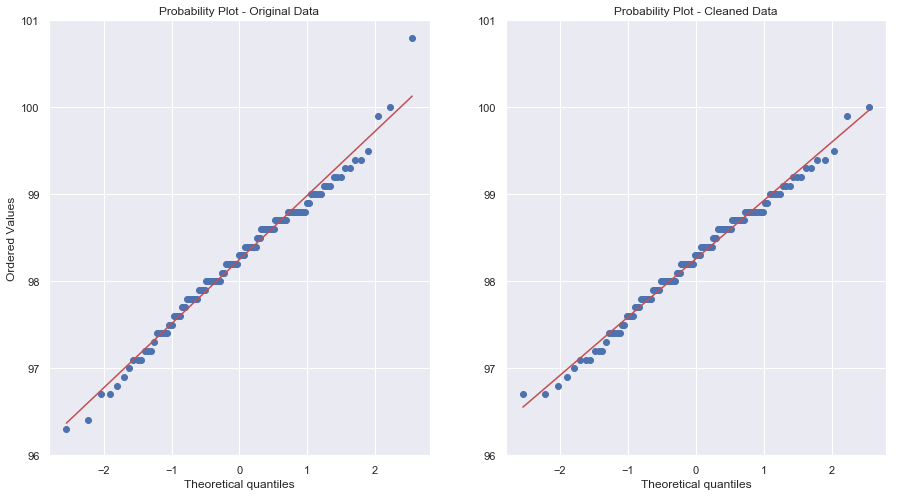

In [370]:
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(121)
_ = stats.probplot(temp , dist="norm", plot=plt)
ax1.set_ylim([96,101])
ax1.set_title('Probability Plot - Original Data')
ax2 = plt.subplot(122)
_ = stats.probplot(temp_clean , dist="norm", plot=plt)
ax2.set_ylabel('')
ax2.set_ylim([96,101])
ax2.set_title('Probability Plot - Cleaned Data')
plt.show()

Both the distribtuion and quantile-quantile plots suggest the original and cleaned data hace almost normal distribution.
We now move our focus on normaility tests. Among the various tests available via scipy library two were chosen.
1. Normaltest : based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.
2. KStest: compares the two empirical CDFs of sample distribution and referenced distribution.
    
For both tests we will assume same hypothesis conditions:
    
H(null) = Sample comes from a normal distribution

H(alternate) = Sample does not come from a normal distribtuion

For all cases we will assume a significance level of 0.05.

## Normal test
Returns two values:
    
statistic : s^2 + k^2, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest.
    
pvalue : A 2-sided chi squared probability for the hypothesis test.

In [371]:
alpha = 0.05

s, pval = stats.normaltest(temp)
if pval < alpha:
    print('Normality test p-value %0.4f suggests that null hypothesis can be rejected.'%pval)
else:
    print('Normality test p-value %0.4f suggests that the null hypothesis cannot be rejected.'%pval)

Normality test p-value 0.2587 suggests that the null hypothesis cannot be rejected.


## KS Normality Test

KS test compares the two ECDFs - sample distribution and referenced distribution.
Referenced normal distribution is generated using the sample data mean and standard deviation.

KS test outputs two statistics (1) difference in the ECDF fit, (2) p-value

In [372]:
D, pval = stats.kstest(temp, 'norm', args = (mu,sigma) )
if pval < alpha:
    print('KS test p-value %0.4f suggests that null hypothesis can be rejected.'%pval)
else:
    print('KS test p-value %0.4f suggests that the null hypothesis cannot be rejected.'%pval)


KS test p-value 0.6645 suggests that the null hypothesis cannot be rejected.


## Empirical Cumulative Distribution Function (EDCF)
Following functions plots the ECDF of a 1-D array. 
We plots the ECDF of the simulated normal distribution and compare it with the sample data ECDF.

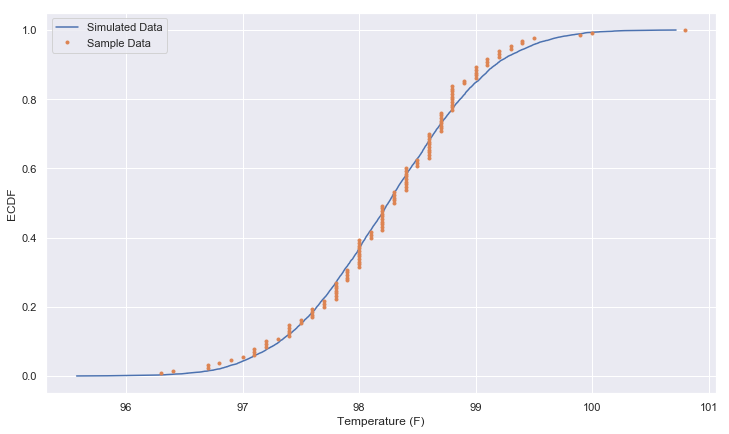

In [373]:
def ecdf(x):
    """ Function to produce the x,y ECDF data"""
    n = len(x)
    x_new = np.sort(x)
    y = np.arange(1,n+1)/n
    return x_new,y

# Simulated normal distribution
x_simulated,y_simulated = ecdf(np.random.normal(mu,sigma,size = 10000))
# ECDF of sample temperature data
x_sample,y_sample = ecdf(temp)
# Plot the two ECDF results to compare the KS test results
plt.figure(figsize=(12, 7))
plt.plot(x_simulated,y_simulated)
plt.plot(x_sample,y_sample,marker = '.', linestyle = 'none')
plt.legend(['Simulated Data', 'Sample Data'])
plt.ylabel('ECDF')
plt.xlabel('Temperature (F)')
plt.show()

# Note on Sample Size
We have about 130 mean readings. Assuming that there hasn't been much change for more than 1200 years we can assume
that the data points (<10% of actual number of years human are around) are independent.

# Hypothesis Testing
Null Hypothesis: Mean body temperature is 98.6
Alternate Hypothesis: Mean body temperature is not 98.6

We first look at the provided data and try to find how rare these measurements are given null hypothesis is true.

In [374]:
temp_mean = np.mean(temp)
print("Mean Temperature from measuered data: %0.1f "% temp_mean)

Mean Temperature from measuered data: 98.2 


The hypothesis test will be one sided as we have just one data point claiming 98.6 as mean body temp.
So as first step we shift the data to this mean value.

In [376]:
temp_shifted = temp - temp_mean + 98.6

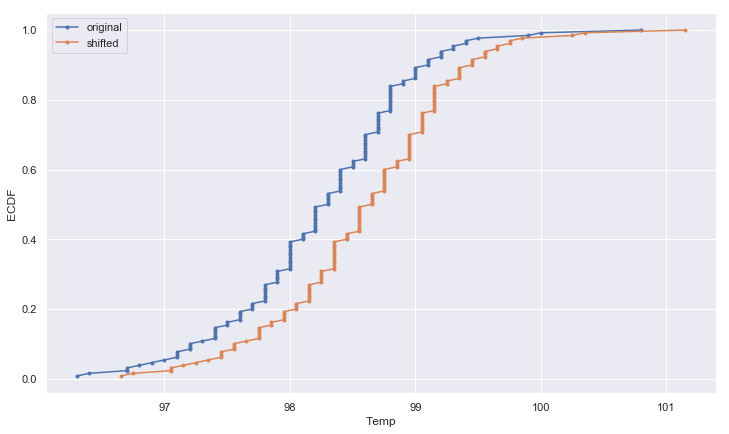

In [439]:
x, y = ecdf(temp)
xn, yn = ecdf(temp_shifted)

plt.figure(figsize=(12, 7)) 

plt.plot(x, y, marker='.')
plt.plot(xn, yn, marker='.')
plt.legend(['original', 'shifted'])
plt.xlabel('Temp')
plt.ylabel('ECDF')
plt.show()


In [378]:
# Function to Draw bootstrap samples for simulations
def draw_bs_reps(data, func, size=1):
    """
    Draw bootstrap replicates.
    input:
    data = 1D array
    func = function that computes the test statistics
    size = # of simulations
    output:
    bs_replicates = test statistics from each simulation
    """
    
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates


## Bootstrap Hypothesis test

Null Hypothesis: True population mean is 98.6
Alternate Hypothesis: True population mean is not 98.6

A few points to note:

1. Since we do not have actual population data but just a claim of true mean. = 98.6 F, the samples test
will be one sided.
2. Our main goal is to see if true mean is actaully 98.6, what is the probability of getting sample mean value of 
98.2 or less.
3. We run 10,000 bootstrap simulations and record the mean from each simulated sample.
5. We compute the proportion of means that are atleast as far from the true mean as the sample mean is. This is called
the p-value. 
6. If p-value is less than the significance level of 0.05 (5.0%) we reject the null hypothesis. Otherwise
we can not reject the null hypothesis.

p = 0.00 %
p-value 0.0000 suggests that null hypothesis can be rejected.


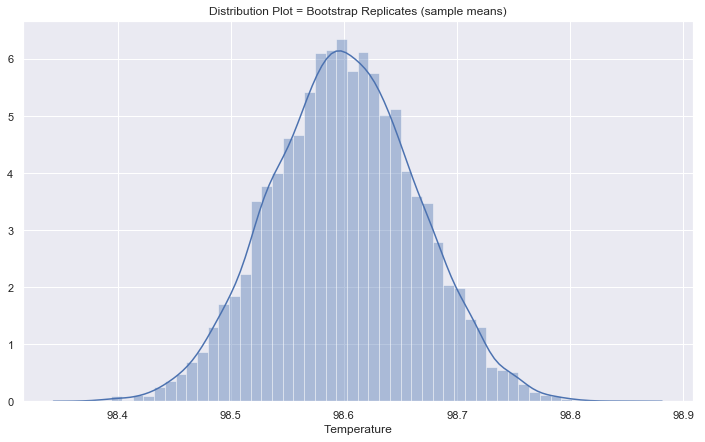

In [379]:
n_sim = 10000
true_mu = 98.6
bs_replicates = draw_bs_reps(temp_shifted, np.mean, n_sim)
diff = true_mu - mu
low, high = true_mu-diff, true_mu+diff
p = (np.sum(bs_replicates <= low)+np.sum(bs_replicates >= high)) / n_sim
# Print the p-value
print('p = %0.2f'% (p*100),'%')
if p < alpha:
    print('p-value %0.4f suggests that null hypothesis can be rejected.'%p)
else:
    print('p-value %0.4f suggests that the null hypothesis cannot be rejected.'%p)

plt.figure(figsize=(12, 7))
_= sns.distplot(bs_replicates)
_= plt.xlabel('Temperature')
_ = plt.title('Distribution Plot = Bootstrap Replicates (sample means)')

#  Frequentist Statistical Testing

We have option of using either z- or t- statistics here as the number of sample points are more than 30.
But z-statistic has one major assumption that the sample standard deviation is same as population standard deviations.
We do not know the sample standard deviation. So we can either assume that the sample and population standard deviation
is same or we can use the t statistic which mainly depends on the sample mean, sample variance and degree of freedom of sample.

Thus out of the two t-statistic is prefered. Below we will compute the results using both statistics.
For t-statistic we need to measure the sample variance.
For z-statistic we assumed that sample standard deviation is population standard deviation.

Below we will compute the results using the standard formulas and built in functions in stats library.

## t-Statistic

In [380]:
# USING THE BASIC FORMULA

# Computing Sample Variance
# Number of sample points
n  = len(temp)
# Degree of Freedom
df = n-1
# Residual from sample mean
dist = temp - mu 
# Sample Variance
sample_var = np.dot(dist,dist)/(n-1)
# Compute t-statistic
tt = (mu-true_mu)/np.sqrt(sample_var/n)
# Compute p-value
pt = 2*stats.t.cdf(tt, df)

print('Value of t-statistic:  ', tt)
print('P-value computed using t-statistic: ', pt)

if pt < alpha:
    print('\n p-value',pt,' suggests that null hypothesis can be rejected.'%p)
else:
    print('\n p-value',pt,' suggests that the null hypothesis cannot be rejected.'%p)

Value of t-statistic:   -5.4548232923645195
P-value computed using t-statistic:  2.4106320415561276e-07

 p-value 2.4106320415561276e-07  suggests that null hypothesis can be rejected.


In [381]:
# USING LIBRARY FUNCTION
tt,pt = stats.ttest_1samp(temp, true_mu)

print('Value of t-statistic:  ', tt)
print('P-value computed using t-statistic: ', pt)

if pt < alpha:
    print('\n p-value',pt,' suggests that null hypothesis can be rejected.'%p)
else:
    print('\n p-value',pt,' suggests that the null hypothesis cannot be rejected.'%p)

Value of t-statistic:   -5.4548232923645195
P-value computed using t-statistic:  2.4106320415561276e-07

 p-value 2.4106320415561276e-07  suggests that null hypothesis can be rejected.


## z-Statistic

In [382]:
# USING THE BASIC FORMULA

# Compute z-statistic
tz = (mu-true_mu)/np.sqrt(sample_var/n)
# Compute p-value
pz = 2*stats.norm.cdf(z)

print('Value of t-statistic:  ', tz)
print('P-value computed using z-statistic: ', pz)

if pz < alpha:
    print('\n p-value',pz,' suggests that null hypothesis can be rejected.'%pz)
else:
    print('\n p-value',pz,' suggests that the null hypothesis cannot be rejected.'%pz)

Value of t-statistic:   -5.4548232923645195
P-value computed using z-statistic:  4.9021570141012155e-08

 p-value 4.9021570141012155e-08  suggests that null hypothesis can be rejected.


In [383]:
# USING LIBRARY FUNCTION
from statsmodels.stats.weightstats import ztest
tz, pz = ztest(temp,value = true_mu)

print('Value of z-statistic:  ', tz)
print('P-value computed using z-statistic: ', pz)

if pz < alpha:
    print('\n p-value',pz,' suggests that null hypothesis can be rejected.'%pz)
else:
    print('\n p-value',pz,' suggests that the null hypothesis cannot be rejected.'%pz)

Value of z-statistic:   -5.4548232923645195
P-value computed using z-statistic:  4.9021570141012155e-08

 p-value 4.9021570141012155e-08  suggests that null hypothesis can be rejected.


We were able to match the test statistics using built-in and formula based calculations.
Both statistics indicate that the the null hypothesis should be rejected (in line with bootstrap hypothesis test).

p-value computed using t-statistic was 20 times that computed using z- statistic.

# Small Samples

Reducing the sample size to 10 violates the normalization condition. Thus we can no rely on the results of t- or
z- statistic. The statistic computations using a sample size of 10 was repeated 50 times. The plots show that both
statistics performed poorly as the data was not normally distributed and thus the results are not reliable.

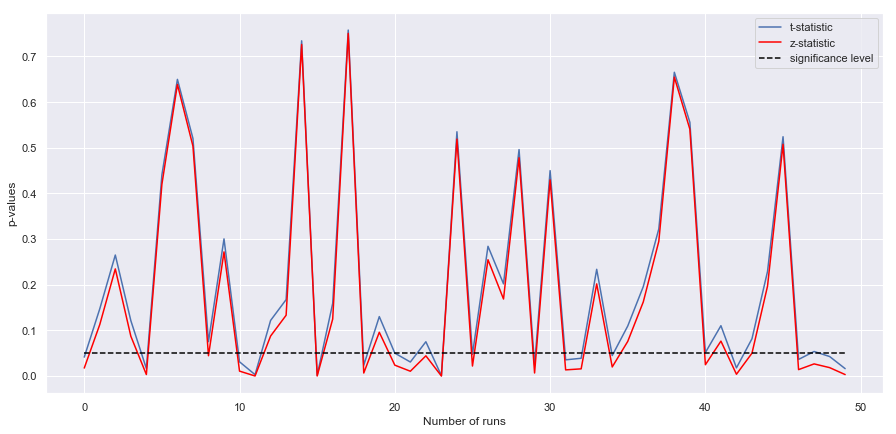

In [386]:
# Draw a random sample of size 10 without replacement
pt = np.empty(50)
pz = np.empty(50)
for i in range(50):
    small_sample = np.random.choice(temp, size = 10, replace = False)
    t_t,pt[i] = stats.ttest_1samp(small_sample, true_mu)
    t_z,pz[i] = ztest(small_sample,value = true_mu)

plt.figure(figsize=(15, 7))
_ = plt.plot(pt)
_ = plt.plot(pz, color = 'red')
_ = plt.plot(np.ones(50)*0.05, color = 'black', linestyle = '--')
_ = plt.xlabel('Number of runs')
_ = plt.ylabel('p-values')
_ = plt.legend(['t-statistic','z-statistic','significance level'], loc = 'top left')
_ = plt.show

# Testing for Abnormalities

Since we do not know the true distribution we assume that the sample data mimics the population distribution,
in the sense that sample mean and sample standard deviation are population mean and population standard deviation.

## Bootstrap Approach

From the distribution plot of bootstrap replicates we see that data is nomrally distribtuted.
Since we esptablished out significance level at 5% we consider anything outside the 95% confidence interval
would be considered abnormal temperature.



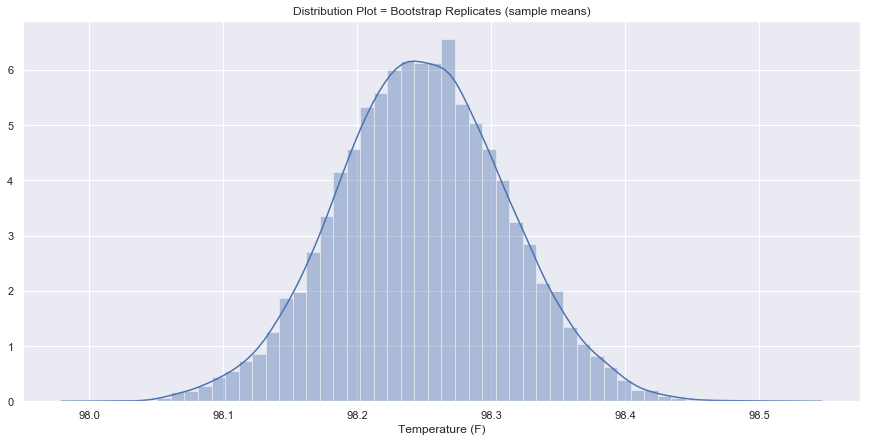

In [388]:
# Draw Bootstrap replicate
n_sim = 10000
bs_replicates = draw_bs_reps(temp, np.mean, n_sim)
plt.figure(figsize=(15, 7))
_ = sns.distplot(bs_replicates)
_= plt.xlabel('Temperature (F)')
_ = plt.title('Distribution Plot = Bootstrap Replicates (sample means)')

In [389]:
# Standard deviation of the sampling distribution of bootstrap replications
std_error = np.std(bs_replicates)

# Margin of Error = 95% CI = 2 x Std_error
moe = 2*std_error

print('Margin of error of the bootstrap sampling distribution is: ', moe)
print('\nConfidence interval is: Mean + 2xStandard Error, Mean - 2xStandard Error]:')
      
print('[%0.2f F'%(np.mean(bs_replicates)-moe) ,', %0.2f F'%(np.mean(bs_replicates)+moe),']')
print('\nAbnormal temperature range:')
print('Anything above: %0.2f F'% (np.mean(bs_replicates)+moe))
print('Anything below: %0.2f F'% (np.mean(bs_replicates)-moe))



Margin of error of the bootstrap sampling distribution is:  0.12691001128004314

Confidence interval is: Mean + 2xStandard Error, Mean - 2xStandard Error]:
[98.12 F , 98.38 F ]

Abnormal temperature range:
Anything above: 98.38 F
Anything below: 98.12 F


## Frequentist Approach

In [390]:
# Standard deviation using sample variance
sample_std = np.sqrt(sample_var/n)

# Margin of Error = 95% CI = 1.96 x Std_error
moe = 1.96*sample_std

print('Margin of error of the bootstrap sampling distribution is: ', moe)
print('\nConfidence interval is: Mean + 1.96xStandard Deviation, Mean - 1.96xStandard Deviation]:')
      
print('[%0.2f F'%(np.mean(temp)-moe) ,', %0.2f F'%(np.mean(temp)+moe),']')
print('\nAbnormal temperature range:')
print('Anything above: %0.2f F'% (np.mean(temp)+moe))
print('Anything below: %0.2f F'% (np.mean(temp)-moe))

Margin of error of the bootstrap sampling distribution is:  0.1260366570022664

Confidence interval is: Mean + 1.96xStandard Deviation, Mean - 1.96xStandard Deviation]:
[98.12 F , 98.38 F ]

Abnormal temperature range:
Anything above: 98.38 F
Anything below: 98.12 F


Note that both appraoches provide approximately same 95% CI for temperature range, suggesting the importance of t-statistic.

# Difference Between Male and Female Body Temperature

We extract the results for male and female body temperature in two different arrays.

These become two different sample data sets and we use two-sided t-statistic to compute the difference between both.

Null Hypothesis: There is no significant difference between male and female normal temperature
Alternate Hypothesis: Male and female body temperatures are signifcantly different.
    
We will assume the significance level of 5%.

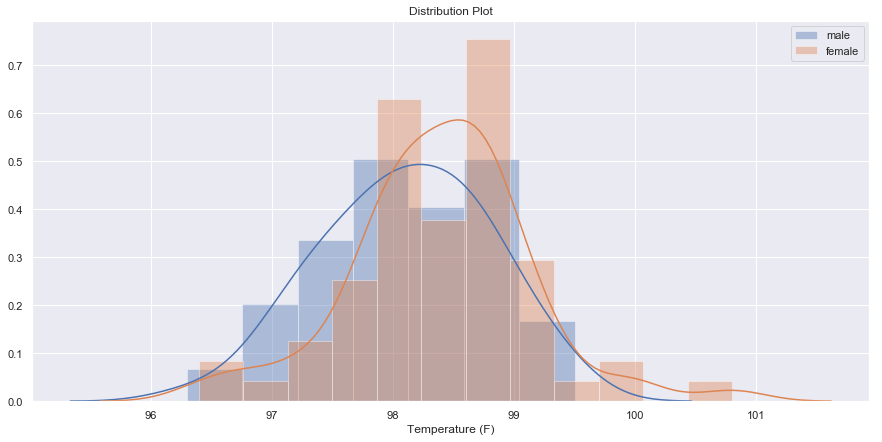

In [422]:
male_temp = df.loc[(df.gender == 'M')].temperature
female_temp = df.loc[(df.gender == 'F')].temperature
plt.figure(figsize=(15, 7))
_ = sns.distplot(male_temp)
_ = sns.distplot(female_temp)
_ = plt.legend(['male','female'])
_ = plt.xlabel('Temperature (F)')
_ = plt.title('Distribution Plot')

In [423]:
t, p = stats.ttest_ind(male_temp, female_temp)
print('Value of t-statistic:  ', t)
print('P-value computed using t-statistic: ', p)
if p < alpha:
    print('\n p-value',p,' suggests that null hypothesis can be rejected.'%p)
else:
    print('\n p-value',p,' suggests that the null hypothesis cannot be rejected.'%p)

Value of t-statistic:   -2.2854345381656103
P-value computed using t-statistic:  0.02393188312239561

 p-value 0.02393188312239561  suggests that null hypothesis can be rejected.


Based on the above result we conclude that there is a significant temperature difference between the male and females.

The difference is also confirmed using the ECDF and box plots below.

There are 4 outlies in the female temperature data while there are not sample outliers for men.

Also based on the sample data mean temperature of females is higher then male.

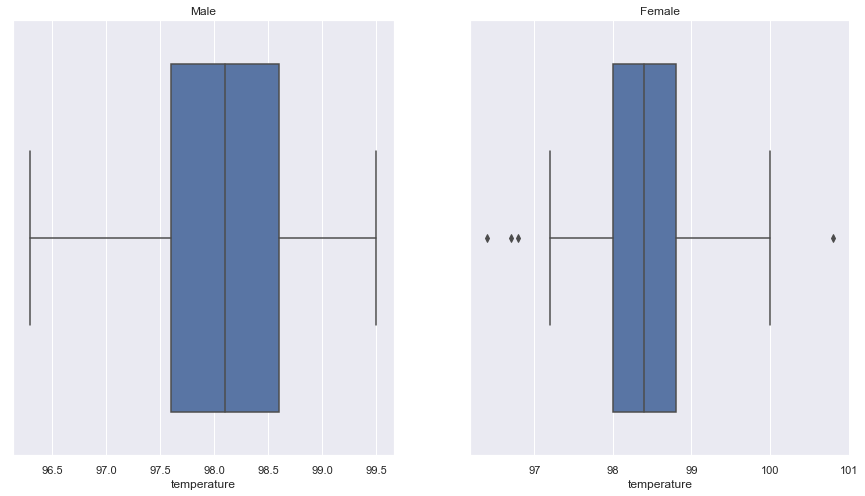

In [437]:
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(121)

ax1.set_title('Male')
_ = sns.boxplot(male_temp)
ax2 = plt.subplot(122)
_ = sns.boxplot(female_temp)
_ = ax2.set_title('Female')

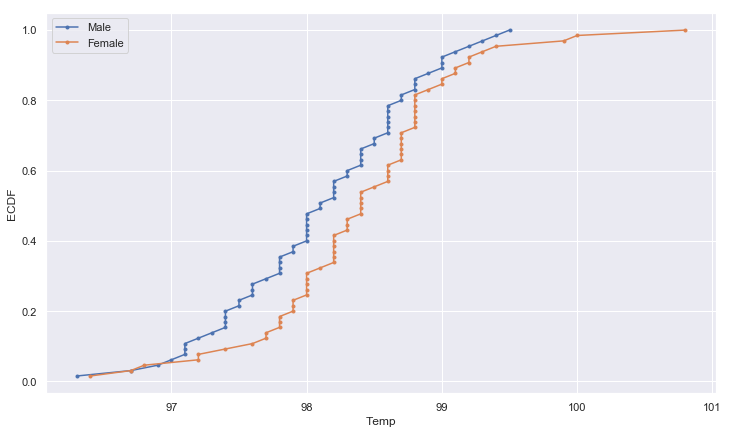

In [438]:
xm,ym = ecdf(male_temp)
xf,yf = ecdf(female_temp)

plt.figure(figsize=(12, 7))
plt.plot(xm, ym, marker='.')
plt.plot(xf, yf, marker='.')
plt.legend(['Male', 'Female'])
plt.xlabel('Temp')
plt.ylabel('ECDF')
plt.show()

p-value suggests that we can not reject the null hypothesis